# Import

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_qsphere, plot_histogram
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
from qiskit import transpile
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit.library import UnitaryGate, QFT

from scipy.linalg import ishermitian
from fractions import Fraction
from scipy.linalg import expm
from copy import deepcopy

In [43]:
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)

circuit.barrier()
fig = circuit.draw()

In [ ]:
def qft_dagger(circ, q, n):
    circ.h(clock[1]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.crz(-np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[0]);
    circ.swap(clock[0], clock[1]);

def qft(circ, q, n):
    circ.swap(clock[0], clock[1]);
    circ.h(clock[0]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.crz(np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[1]);

In [ ]:
def qpe(circ, clock, target):
    circuit.barrier()

    # e^{i*A*t}
    circuit.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], input, label='U');

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    circuit.barrier();

    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock, 2)

def inv_qpe(circ, clock, target):

    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock, 2)

    circuit.barrier()

    # e^{i*A*t*2}
    circuit.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    #circuit.barrier();

    # e^{i*A*t}
    circuit.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], input, label='U');

    circuit.barrier()

In [ ]:
def hhl(circ, ancilla, clock, input, measurement):

    qpe(circ, clock, input)

    circuit.barrier()

    # This section is to test and implement C = 1
    circuit.cry(np.pi, clock[0], ancilla)
    circuit.cry(np.pi/3, clock[1], ancilla)

    circuit.barrier()

    circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

In [ ]:
# State preparation.
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, input, measurement)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()


circuit.measure(input, measurement[1])

In [ ]:
circuit.draw()

░       ░                                       »
ancilla: ────────────────────░───────░───────────────────────────────────────»
                             ░ ┌───┐ ░            U                          »
clock_0: ────────────────────░─┤ H ├─░────────────■──────────────────────────»
                             ░ ├───┤ ░            │                  U2      »
clock_1: ────────────────────░─┤ H ├─░────────────┼──────────────────■───────»
         ┌─────────────────┐ ░ └───┘ ░ ┌──────────┴───────────┐┌─────┴──────┐»
      b: ┤ Initialize(0,1) ├─░───────░─┤ U(π/2,-π/2,π/2,3π/4) ├┤ U(π,π,0,0) ├»
         └─────────────────┘ ░       ░ └──────────────────────┘└────────────┘»
    c: 2/════════════════════════════════════════════════════════════════════»
                                                                             »
«          ░                           ░ ┌───────┐┌─────────┐ ░ ┌─┐ ░         »
«ancilla: ─░───────────────────────────░─┤ Ry(π) ├┤ Ry(π/3) ├─░─┤M├─░─────────»
«          ░      ┌──────────┐┌───┐    ░ └───┬───┘└────┬────┘ ░ └╥┘ ░    ┌───┐»
«clock_0: ─░──────┤ Rz(-π/2) ├┤ H ├─X──░─────■─────────┼──────░──╫──░──X─┤ H ├»
«          ░ ┌───┐└────┬─────┘└───┘ │  ░               │      ░  ║  ░  │ └───┘»
«clock_1: ─░─┤ H ├─────■────────────X──░───────────────■──────░──╫──░──X──────»
«          ░ └───┘                     ░                      ░  ║  ░         »
«      b: ─░───────────────────────────░──────────────────────░──╫──░─────────»
«          ░                           ░                      ░  ║  ░         »
«    c: 2/═══════════════════════════════════════════════════════╩════════════»
«                                                                0            »
«                          ░                                         ░       ░ »
«ancilla: ─────────────────░─────────────────────────────────────────░───────░─»
«         ┌─────────┐      ░                           U             ░ ┌───┐ ░ »
«clock_0: ┤ Rz(π/2) ├──────░───────────────────────────■─────────────░─┤ H ├─░─»
«         └────┬────┘┌───┐ ░       U2                  │             ░ ├───┤ ░ »
«clock_1: ─────■─────┤ H ├─░───────■───────────────────┼─────────────░─┤ H ├─░─»
«                    └───┘ ░ ┌─────┴──────┐┌───────────┴───────────┐ ░ └───┘ ░ »
«      b: ─────────────────░─┤ U(π,π,0,0) ├┤ U(π/2,π/2,-π/2,-3π/4) ├─░───────░─»
«                          ░ └────────────┘└───────────────────────┘ ░       ░ »
«    c: 2/═════════════════════════════════════════════════════════════════════»
«                                                                              »
«            
«ancilla: ───
«            
«clock_0: ───
«            
«clock_1: ───
«         ┌─┐
«      b: ┤M├
«         └╥┘
«    c: 2/═╩═
«          1

In [ ]:
backend = AerSimulator(method="statevector") # downloading simulator
tqc = transpile(circuit, backend)
result = backend.run(tqc, shots=1024).result()
print(result)


Result(backend_name='aer_simulator_statevector', backend_version='0.17.2', job_id='44101417-1852-4460-a0cd-ed961ed10fcf', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 189, '0x2': 208, '0x3': 565, '0x1': 62}), header={'creg_sizes': [['c', 2]], 'global_phase': 0.0, 'memory_slots': 2, 'n_qubits': 4, 'name': 'circuit-56', 'qreg_sizes': [['ancilla', 1], ['clock', 2], ['b', 1]], 'metadata': {}}, status=DONE, seed_simulator=1128673675, metadata={'time_taken': 0.001626012, 'num_bind_params': 1, 'parallel_state_update': 2, 'parallel_shots': 1, 'required_memory_mb': 1, 'input_qubit_map': [[3, 3], [2, 2], [1, 1], [0, 0]], 'method': 'statevector', 'device': 'CPU', 'num_qubits': 4, 'sample_measure_time': 0.000281307, 'active_input_qubits': [0, 1, 2, 3], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 12975, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization':

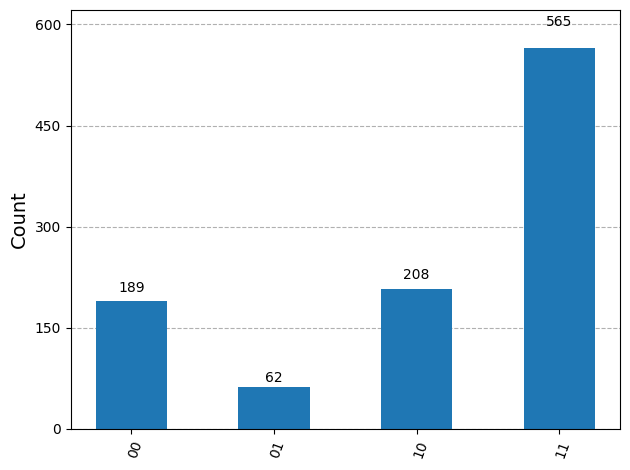

In [ ]:
plot_histogram(result.get_counts(tqc))

In [ ]:
x_c = (9/8)/(3/8)
print("classical solution ratio:", x_c)

x_quantum = (599)/(67)
print("quantum solution ratio:", x_quantum)

classical solution ratio: 3.0
quantum solution ratio: 8.940298507462687


In [ ]:
circuit.clear()

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService #new library
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
QiskitRuntimeService.save_account(
 ...
)
provider = QiskitRuntimeService()


qiskit_runtime_service.__init__:WARNING:2026-02-07 18:54:09,766: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


In [ ]:
provider.backends()


qiskit_runtime_service.backends:WARNING:2026-02-07 18:59:23,999: Loading instance: open-instance, plan: open


[<IBMBackend('ibm_fez')>,
 <IBMBackend('ibm_marrakesh')>,
 <IBMBackend('ibm_torino')>]

In [ ]:
backend = provider.backend("ibm_torino")

tqc = transpile(
    circuit,
    backend,
    optimization_level=0,
    layout_method="trivial",
    routing_method="basic"
)
sampler = Sampler(mode=backend)
job_simulator = sampler.run([tqc], shots=1024)


result_simulator = job_simulator.result()

publicResult = result_simulator[0]
counts = publicResult.join_data().get_counts()

print(counts)
plot_histogram(counts)


print("\n")
print(publicResult)

qiskit_runtime_service.backends:WARNING:2026-02-07 19:41:45,093: Using instance: open-instance, plan: open


{'10': 235, '00': 210, '01': 159, '11': 420}


SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}})


In [ ]:
import qiskit
print(qiskit.__version__)


2.3.0


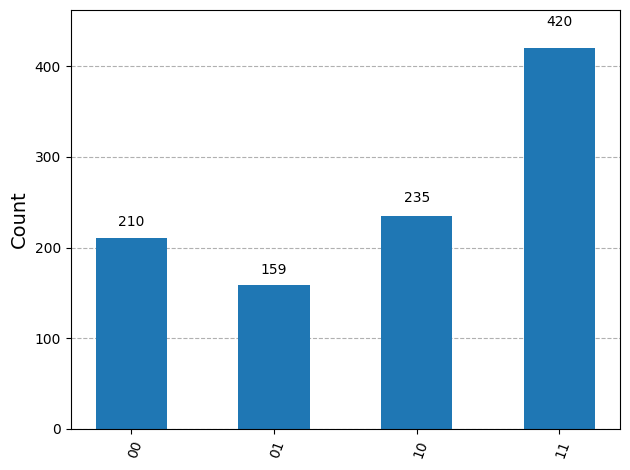

In [ ]:
plot_histogram(counts)

In [ ]:
x_c = (9/8)/(3/8)
print("classical solution ratio:", x_c)

x_quantum = (420)/(159)
print("quantum solution ratio:", x_quantum)

classical solution ratio: 3.0
quantum solution ratio: 2.641509433962264


In [29]:
A = [[1, -1/3], [-1/3, 1]]
b = [0, 1]

[0.1 0.9]


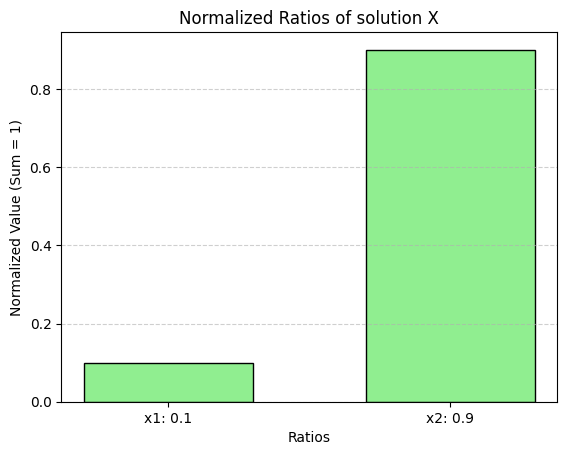

In [32]:
x = np.linalg.solve(A, b)
x_sq = x**2
x_sq_norm = x_sq / np.sum(x_sq)


x_positions = np.arange(len(x_sq_norm))
plt.bar(x_positions, x_sq_norm, color='lightgreen', edgecolor='black', width=0.6)
labels = [f'x1: {x_sq_norm[0]}', f'x2: {x_sq_norm[1]}']

# Formatting
plt.xticks(x_positions, labels)  # Map the even positions to our ratio labels
plt.xlabel('Ratios')
plt.ylabel('Normalized Value (Sum = 1)')
plt.title('Normalized Ratios of solution X')
plt.grid(axis='y', linestyle='--', alpha=0.6)

print(x_sq_norm)

In [40]:
counts = {'10': 235, '00': 210, '01': 159, '11': 420}

counts_anc1 = {k: v for k, v in counts.items() if k[-1] == "1"}
total_anc1 = sum(counts_anc1.values())
counts_anc1_norm = {k: v / total_anc1 for k, v in counts_anc1.items()} if total_anc1 else {}


Sum = 1.0


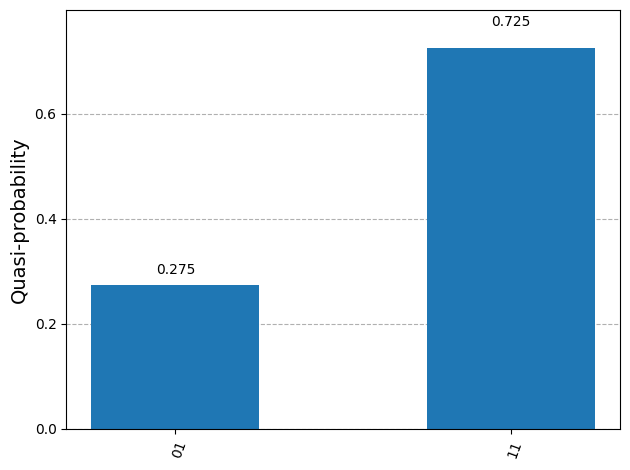

In [41]:

fig = plot_histogram(counts_anc1_norm)
print("Sum =", sum(counts_anc1_norm.values()))
display(fig)


In [43]:
print(x)

[0.375 1.125]


Sum = 1.0


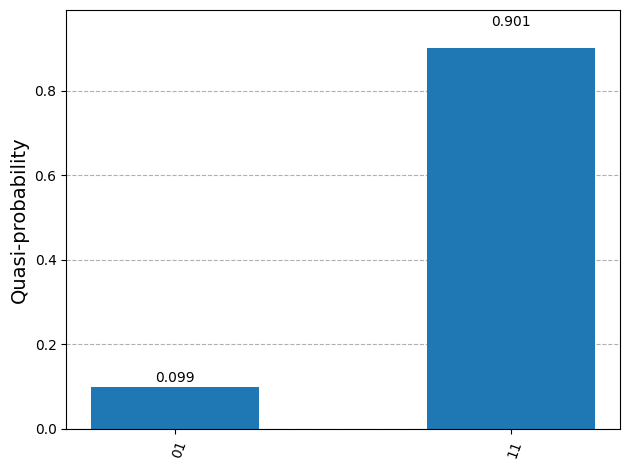

In [44]:
counts = {'10': 208, '00': 189, '01': 62, '11': 565}

counts_anc1 = {k: v for k, v in counts.items() if k[-1] == "1"}
total_anc1 = sum(counts_anc1.values())
counts_anc1_norm = {k: v / total_anc1 for k, v in counts_anc1.items()} if total_anc1 else {}

fig = plot_histogram(counts_anc1_norm)
print("Sum =", sum(counts_anc1_norm.values()))
display(fig)